# DS4A / COLOMBIA 4.0 

# Topic: Consumer behavior on e-Commerce

Data science for the digital future

- Ximena Rios Cotazo

- Ramon Manuel Sandoval 

- Luisa Maria Carabali

- Alejandro Camargo Garcia

- Cristian Sarmiento

- Hector Melo


## E-Commerce 

This is a Brazilian ecommerce public dataset of orders made at Olist Store. The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. Its features allows viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers. We also released a geolocation dataset that relates Brazilian zip codes to lat/lng coordinates.

This is real commercial data, it has been anonymised, and references to the companies and partners in the review text have been replaced with the names of Game of Thrones great houses.


## Context

This dataset was generously provided by Olist, the largest department store in Brazilian marketplaces. Olist connects small businesses from all over Brazil to channels without hassle and with a single contract. Those merchants are able to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners. See more on our website: www.olist.com

After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. Once the customer receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey by email where he can give a note for the purchase experience and write down some comments.

Taken from:[Kaggle](https://www.kaggle.com/olistbr/brazilian-ecommerce?select=olist_geolocation_dataset.csv )

## Topic: Consumer behavior on E-Commerce

## Research question

What aspects of consumers’ online behavior is useful for businesses to better understand their customers and predict consumer trends, spending habits, variables related to the shopping? 

## Objectives: 

-	Data understanding and cleaning
-	Analysis and modeling 
-	Build prediction models 
-	Build dashboards to visualize the insight

## Description of the relationship between datasets:

<img src="VisualData.png">





## Requirements

In [1]:
import os
from scipy import stats
import statsmodels.formula.api as sfm
from statsmodels.formula.api import ols
import statsmodels.api as sm
import sklearn.metrics as Metrics

In [2]:
# Ignore user warnings
import warnings
warnings.simplefilter("ignore", UserWarning)

# Load relevant packages
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pylab

%matplotlib inline
plt.style.use('ggplot')

In [3]:
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression

In [4]:
ruta=os.getcwd()+'/data/'

In [5]:
customer = pd.read_csv(ruta+'olist_customers_dataset.csv', delimiter=',') 
order_items=pd.read_csv(ruta+'olist_order_items_dataset.csv', delimiter=',') 
orders=pd.read_csv(ruta+'olist_orders_dataset.csv', delimiter=',') 
products=pd.read_csv(ruta+'olist_products_dataset.csv', delimiter=',') 
order_payments=pd.read_csv(ruta+'olist_order_payments_dataset.csv', delimiter=',')
reviews=pd.read_csv(ruta+'olist_order_reviews_dataset.csv', delimiter=',')
order_items=pd.read_csv(ruta+'olist_order_items_dataset.csv', delimiter=',') 
sellers=pd.read_csv(ruta+'olist_sellers_dataset.csv', delimiter=',') 
order_reviews=pd.read_csv(ruta+'olist_order_reviews_dataset.csv', delimiter=',') 


# INICIO XIMENA

In this part we try to analyze which is the trend of online shopping by city.

For this analysis we generate a dataset called ```df```, which is obtained by crossing the fields: ```order_id,customer_id```, ```customer_unique_id```, ```ustomer_city,customer_state```, ```order_item_id```,  ```product_id```, ```product_category_name```   of the dataframes: ```olist_customers_dataset```, ```olist_order_items_dataset```, ```olist_orders_dataset```, ```olist_products_dataset```. For this we use pyhton's ```merge``` function:

In [6]:
# order_id:Identificador único del pedido. customer_id: Id del cliente.customer_unique_id: Identificador único de un cliente.
df=orders[['order_id','customer_id','order_purchase_timestamp','order_status']] 
aux=customer[['customer_id','customer_city','customer_state']] 
df=pd.merge(df, aux, how="left", left_on="customer_id", right_on="customer_id")

In [7]:
#product_id: Identificador único del producto.order_item_id: identifica el número de artículosincluido en el mismo pedido.
aux=order_items[['order_id','order_item_id','product_id','price','freight_value']] 
aux['total_price']=aux['price'] + aux['freight_value']
df=pd.merge(df, aux, how="left", left_on="order_id", right_on="order_id")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
#product_category_name:Categoría raíz del producto, en portugués
aux=products[['product_id','product_category_name','product_photos_qty','product_weight_g','product_length_cm','product_height_cm','product_width_cm']] 
aux['product_vol']=aux['product_length_cm'] * aux['product_height_cm'] * aux['product_width_cm']
df=pd.merge(df, aux, how="left", left_on="product_id", right_on="product_id")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
#review_score:puntuacion entre 1 y 5
aux=order_reviews[['order_id','review_score']] 
df=pd.merge(df, aux, how="left", left_on="order_id", right_on="order_id")

Incluimos la informacion del tiempo

In [10]:
df['ano_mes']=df['order_purchase_timestamp'].str.split('-', expand=True)[0]+"-"+df['order_purchase_timestamp'].str.split('-', expand=True)[1]
df['ano_mes_dt'] = pd.to_datetime(df['ano_mes'])
df['ano_mes_dia'] = df['order_purchase_timestamp'].str.split(' ', expand=True)[0]
df['ano_mes_dia_dt'] = pd.to_datetime(df['ano_mes_dia'])
df['fecha'] = pd.to_datetime(df['order_purchase_timestamp'])
df['mes']= df['fecha'].dt.month
df['year']=df['fecha'].dt.year
df.ano_mes = df.ano_mes.astype('category')
df['month_codes']= df.ano_mes.cat.codes

The states are by [ISO code](https://es.wikipedia.org/wiki/Anexo:Estados_de_Brasil), we create an dictionary (```estados```) with these codes and the corresponding name, and another dictionary (```regiones```) with the regions for each state, then we add two columns to the dataframe, one with the name of the state and the other with the region, we do this for a more comfortable viewing.

In [11]:
estados= {'AC':'Acre', 'AL':'Alagoas', 'AM':'Amazonas', 'AP':'Amapá', 'BA':'Bahía', 'CE':'Ceará',
          'DF':'Distrito Federal', 'ES':'Espírito Santo', 'GO':'Goiás', 'MA':'Maranhão', 'MG':'Minas Gerais',
          'MS':'Mato Grosso del Sur', 'MT':'Mato Grosso', 'PA':'Pará', 'PB':'Paraíba', 'PE':'Pernambuco',
          'PI':'Piauí', 'PR':'Paraná', 'RJ':'Río de Janeiro', 'RN':'Río Grande del Norte', 'RO':'Rondonia',
          'RR':'Roraima', 'RS':'Río Grande del Sur', 'SC':'Santa Catarina', 'SE':'Sergipe', 'SP':'São Paulo', 'TO':'Tocantins'}
df['name_state']=df['customer_state']
for i in range(len(estados)):
    df["name_state"]=df["name_state"].str.replace(list(estados.keys())[i],list(estados.values())[i])

In [12]:
region = ["Norte","Sur","Sudeste","Nordeste","CentroOeste"]
regiones= {'AC':'Norte', 'AL':'Nordeste', 'AM':'Norte', 'AP':'Norte', 'BA':'Nordeste',
           'CE':'Nordeste', 'DF':'CentroOeste', 'ES':'Sudeste', 'GO':'CentroOeste',
           'MA':'Nordeste', 'MG':'Sudeste', 'MS':'CentroOeste', 'MT':'CentroOeste',
           'PA':'Norte', 'PB':'Nordeste', 'PE':'Nordeste', 'PI':'Nordeste', 'PR':'Sur',
           'RJ':'Sudeste', 'RN':'Nordeste', 'RO':'Norte', 'RR':'Norte', 'RS':'Sur',
           'SC':'Sur', 'SE':'Nordeste', 'SP':'Sudeste', 'TO':'Norte'}
df['regions']=df['customer_state']
for i in range(len(estados)):
    df["regions"]=df["regions"].str.replace(list(regiones.keys())[i],list(regiones.values())[i])

In [13]:
df.regions  = df.regions .astype(pd.api.types.CategoricalDtype(categories=["Norte","Sur","Sudeste","Nordeste","CentroOeste"]))
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114100 entries, 0 to 114099
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   order_id                  114100 non-null  object        
 1   customer_id               114100 non-null  object        
 2   order_purchase_timestamp  114100 non-null  object        
 3   order_status              114100 non-null  object        
 4   customer_city             114100 non-null  object        
 5   customer_state            114100 non-null  object        
 6   order_item_id             113322 non-null  float64       
 7   product_id                113322 non-null  object        
 8   price                     113322 non-null  float64       
 9   freight_value             113322 non-null  float64       
 10  total_price               113322 non-null  float64       
 11  product_category_name     111710 non-null  object        
 12  pr

# Total average price vs timeline 

### Data Exploration


In [14]:
# Calculamos el precio promedio por producto y agregamos la nueva columna
aux=df.groupby('product_id').agg({'price':'mean'}).rename(columns={'price':'price_mean'})
df=pd.merge(df, aux, how="left", left_on="product_id", right_on="product_id")
aux.head(2)

,price_mean
product_id,
00066f42aeeb9f3007548bb9d3f33c38,101.65
00088930e925c41fd95ebfe695fd2655,129.90


In [15]:
# Generamos un df con el total de ventas por producto y una lista ordenada de productos en forma descendente
df_PS=df.groupby('product_id').size().to_frame().rename(columns={0:'total_product_sales'}).sort_values('total_product_sales', ascending=False).reset_index()
listaProductos=list(df_PS["product_id"]) #lista ordenada de productos en forma descendente
print("The dataframe has ",len(df['product_id'].unique())," products")
df_PS.head(2)

The dataframe has  32952  products


,product_id,total_product_sales
0,aca2eb7d00ea1a7b8ebd4e68314663af,527
1,99a4788cb24856965c36a24e339b6058,491


Precios para este producto:  [ 69.9  75.  109.9  89.9]
['Categoria: moveis_decoracao']


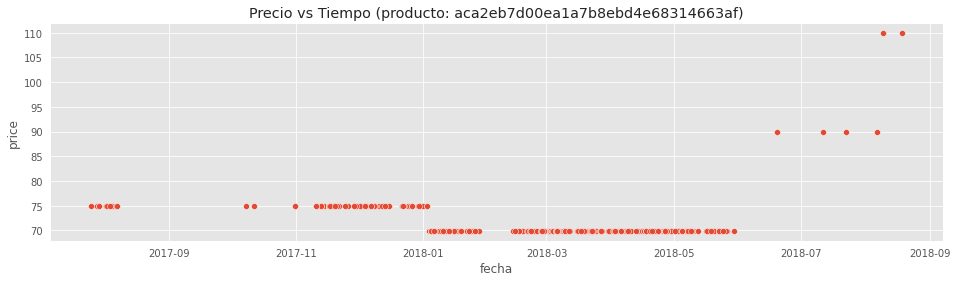

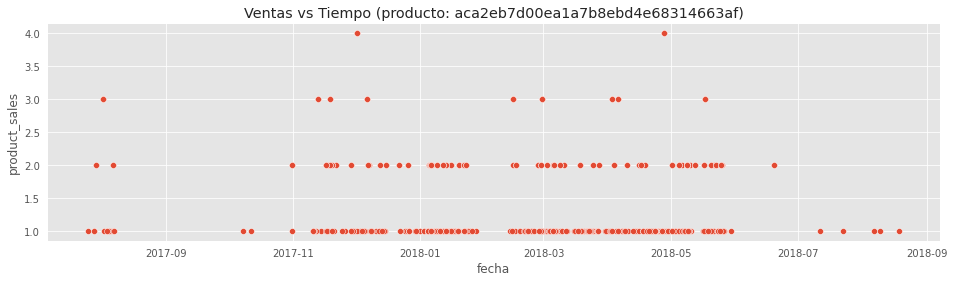

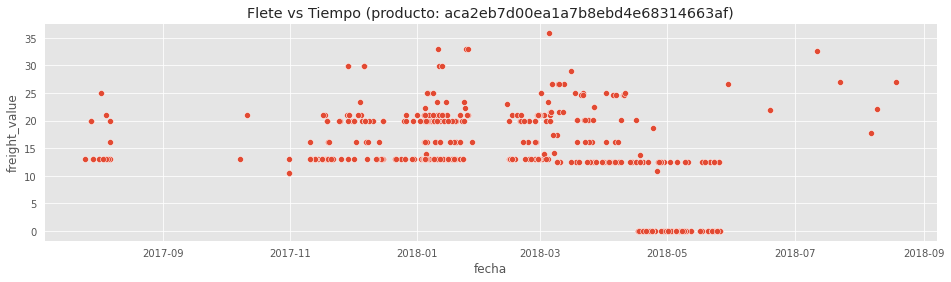

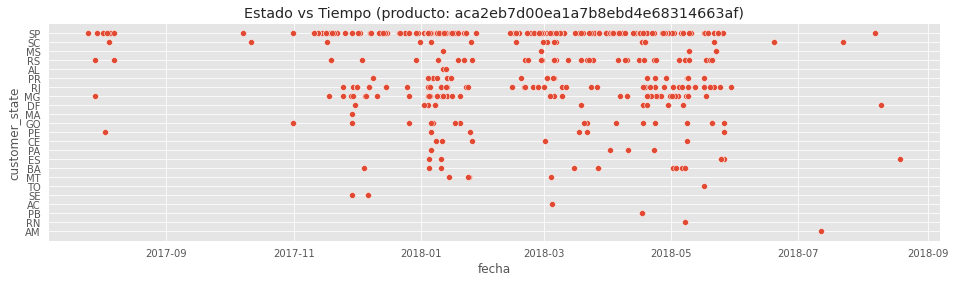

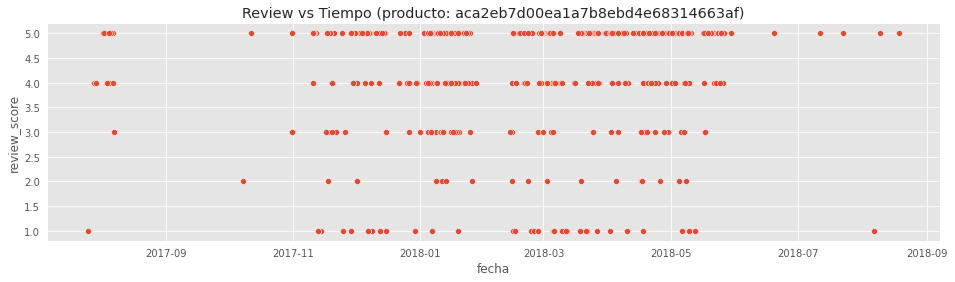

In [16]:
# La misma grafica pero para un solo mes
item=0 #numero entre 0 y 32951 para los diferentes productos
m=3   #numero entre 1 y 12 para los diferentes meses
aux=df[(df["product_id"]==listaProductos[item])]
#aux=aux[(aux["mes"]==m)]  #comentar esta linea para graficar todos los meses 
aux2=aux.groupby(["fecha",'order_id']).size().to_frame().rename(columns={0:'product_sales'}).sort_values('fecha', ascending=True).reset_index()
aux=pd.merge(aux, aux2, how="left", left_on="fecha", right_on="fecha")

plt.figure(figsize=(16, 4))
ax=sns.scatterplot(x='fecha', y='price', data=aux)
ax.set_title('Precio vs Tiempo (producto: '+listaProductos[item]+')')

plt.figure(figsize=(16, 4))
ax=sns.scatterplot(x='fecha', y='product_sales', data=aux)
ax.set_title('Ventas vs Tiempo (producto: '+listaProductos[item]+')')

plt.figure(figsize=(16, 4))
ax=sns.scatterplot(x='fecha', y='freight_value', data=aux)
ax.set_title('Flete vs Tiempo (producto: '+listaProductos[item]+')')

plt.figure(figsize=(16, 4))
ax=sns.scatterplot(x='fecha', y='customer_state', data=aux)
ax.set_title('Estado vs Tiempo (producto: '+listaProductos[item]+')')

plt.figure(figsize=(16, 4))
ax=sns.scatterplot(x='fecha', y='review_score', data=aux)
ax.set_title('Review vs Tiempo (producto: '+listaProductos[item]+')')

print("Precios para este producto: ",aux.price.unique())
print("Categoria: "+aux.product_category_name.unique())

Construyamos un modelo lineal usando las diferentes variables

In [17]:
y = aux.price
X = aux[['freight_value', 'product_sales','review_score']]
X_entren, X_prueb, y_entren, y_prueb = train_test_split(X, y, test_size=0.33,random_state=42)

In [18]:
modelo = LinearRegression().fit(X_entren, y_entren)

In [19]:
print(pd.DataFrame(zip(X_entren.columns, modelo.coef_)))
print('\nintercepto:', modelo.intercept_)
print('r2:', modelo.score(X_prueb,y_prueb))

               0         1
0  freight_value  0.123857
1  product_sales  0.571380
2   review_score  0.201525

intercepto: 67.98033646682845
r2: 0.025042299811068758


In [20]:
pred = modelo.predict(X_prueb)
print('mse', mse(pred, y_prueb))

mse 14.731748997844369


<AxesSubplot:>

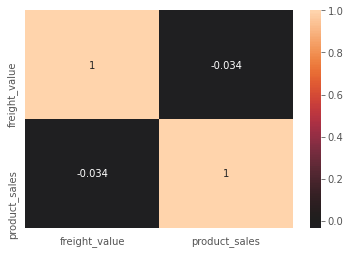

In [21]:
corr =aux[['freight_value', 'product_sales']].corr()
sns.heatmap(corr, center=0, annot=True)

# Ventas vs timeline 

### Data Exploration


Precios para este producto:  [ 69.9  75.  109.9  89.9]
['Categoria: moveis_decoracao']


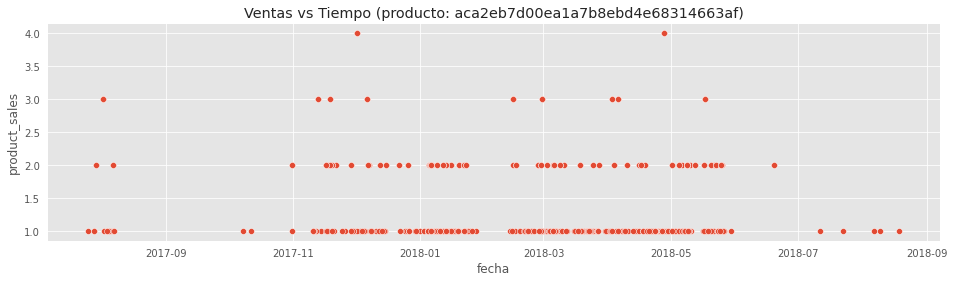

In [22]:
# La misma grafica pero para un solo mes
item=0 #numero entre 0 y 32951 para los diferentes productos
m=3   #numero entre 1 y 12 para los diferentes meses
aux=df[(df["product_id"]==listaProductos[item])]
#aux=aux[(aux["mes"]==m)]  #comentar esta linea para graficar todos los meses 
aux2=aux.groupby(["fecha",'order_id']).size().to_frame().rename(columns={0:'product_sales'}).sort_values('fecha', ascending=True).reset_index()
aux=pd.merge(aux, aux2, how="left", left_on="fecha", right_on="fecha")

plt.figure(figsize=(16, 4))
ax=sns.scatterplot(x='fecha', y='product_sales', data=aux)
ax.set_title('Ventas vs Tiempo (producto: '+listaProductos[item]+')')

print("Precios para este producto: ",aux.price.unique())
print("Categoria: "+aux.product_category_name.unique())

In [23]:
y = aux.product_sales
X = aux[['freight_value', 'price','review_score']]
X_entren, X_prueb, y_entren, y_prueb = train_test_split(X, y, test_size=0.33,random_state=42)

In [24]:
modelo = LinearRegression().fit(X_entren, y_entren)

In [25]:
print(pd.DataFrame(zip(X_entren.columns, modelo.coef_)))
print('\nintercepto:', modelo.intercept_)
print('r2:', modelo.score(X_prueb,y_prueb))

               0         1
0  freight_value -0.006561
1          price  0.022006
2   review_score -0.131075

intercepto: 0.47625334548551757
r2: -0.00540104562226662


In [26]:
pred = modelo.predict(X_prueb)
print('mse', mse(pred, y_prueb))

mse 0.34884852636616165


<AxesSubplot:>

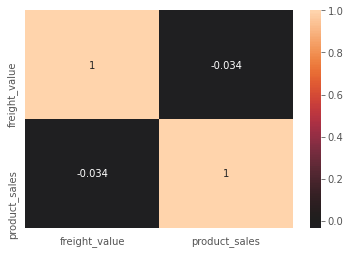

In [27]:
corr =aux[['freight_value', 'product_sales']].corr()
sns.heatmap(corr, center=0, annot=True)

# Total sales per month 

### Data Exploration
Generamos una grafica de las ventas totales por mes

In [28]:
plt.figure(figsize=(16, 4))
aux=df[["ano_mes_dt","codes"]]
aux=aux.groupby(["ano_mes_dt","codes"]).size().to_frame().rename(columns={0:'total_sales'}).sort_values('total_sales', ascending=False).reset_index()
ax=sns.scatterplot(x='ano_mes_dt', y='total_sales', data=aux)
#plt.xticks(rotation=90)
ax.set_title('Total sales per month')
ax.grid()

KeyError: "['codes'] not in index"

<Figure size 1152x288 with 0 Axes>

### Estimando la correlación

Medimos la relación lineal entre las ventas totales y el mes, calculamos la matriz de correlacion para determinar la influencia de la variable:

In [ ]:
corr_mat  = aux[['total_sales','codes']].corr()
corr_mat[['total_sales','codes']][0:1]

### Grafica de la relación lineal

In [ ]:
# relación lineal entre las ventas totales y el mes
sns.lmplot(x='codes',y='total_sales',data=aux,line_kws = {'color': "red"} ,aspect= 2)
plt.title('sales per month');

### Modelo

In [ ]:
formula = 'total_sales~codes'
model   = sfm.ols(formula = formula, data = aux).fit()
print(model.summary())

In [ ]:
# predict
X = sm.add_constant(aux["codes"][:1])
model.predict(X)

# Sales of a product per month

### Data Exploration
Generamos una grafica de las ventas por mes de un producto 

In [ ]:
item=2
plt.figure(figsize=(16, 4))
aux=df[["product_category_name","ano_mes_dt","codes"]]
aux=aux.groupby(["product_category_name","ano_mes_dt","codes"]).size().to_frame().rename(columns={0:'total_sales'}).sort_values('total_sales', ascending=False).reset_index()
listaP=list(aux["product_category_name"])
aux=aux[(aux["product_category_name"]==listaP[item])]
ax=sns.scatterplot(x='ano_mes_dt', y='total_sales', data=aux)
#plt.xticks(rotation=90)
ax.set_title(listaP[item]+' by month')
ax.grid()

### Correlación

Medimos la relación lineal entre las variables, calculamos la matriz de correlacion para determinar la influencia de las variables :

In [ ]:
corr_mat  = aux[['total_sales','codes']].corr()
corr_mat

### Grafica de la relación lineal

In [ ]:
# relación lineal entre las ventas totales y el mes
sns.lmplot(x='codes',y='total_sales',data=aux,line_kws = {'color': "red"} ,aspect= 2)
plt.title(listaP[item]+' by month');

### Modelo

In [ ]:
formula = 'total_sales~codes'
model   = sfm.ols(formula = formula, data = aux).fit()
print(model.summary())

In [ ]:
# predict
X = sm.add_constant(aux["codes"][:1])
model.predict(X)

# Total product sales by region
### Data Exploration
The dataframe has 74 product categories, we generate a graph with the amount of products sold by region and we organize it in descending order.

In [ ]:
plt.figure(figsize=(16, 4))
aux=df[["product_category_name","regions"]]
aux=aux.groupby(["product_category_name","regions"]).size().to_frame().rename(columns={0:'region_sales'}).sort_values('region_sales', ascending=False).reset_index()
#aux=aux[:50]
#ax=sns.lineplot(x='product_category_name', y='region_sales', hue='regions', data=aux)
ax=sns.scatterplot(x='product_category_name', y='region_sales', hue='regions', data=aux)
plt.xticks(rotation=90)
ax.set_title('Total product sales by region')
ax.grid()

### Correlación

Existen factores que podrian impulsar la venta de algunos productos. Seleccionamos algunas variables y medimos la relación lineal entre estas variables y el total de ventas de producto por region usando la correlacion, calculamos la matriz de correlacion para determinar su influencia: 

In [ ]:
print('correlacion de total ventas por region\n')
print('Region   ','price   ', 'freight_value', 'product_photos','review_score','Region',sep='\t')
for R in region:
    aux=df[(df['regions']==R)][['product_category_name','price', 'freight_value', 'product_photos_qty','review_score','regions','order_purchase_timestamp']]
    aux2=aux.groupby('product_category_name').size().to_frame().rename(columns={0:'region_sales'}).sort_values('region_sales', ascending=False).reset_index()
    aux=pd.merge(aux, aux2, how="left", left_on="product_category_name", right_on="product_category_name")
    corr_mat  = aux[['region_sales','price', 'freight_value', 'product_photos_qty','review_score']].corr()
    
    corr_list = corr_mat[['price', 'freight_value', 'product_photos_qty','review_score']][0:1].values.tolist()[0]
    print ('region_sales',round(corr_list[0],6),round(corr_list[1],6),round(corr_list[2],6),round(corr_list[3],6),R,sep='\t')

### Modelo

In [ ]:
formula = 'region_sales~price+review_score+freight_value+product_photos_qty'
model   = sfm.ols(formula = formula, data = aux).fit()
print(model.summary())

# Sale of one item in the region per month

### Data Exploration

In [ ]:
item=0
R='Sudeste'
plt.figure(figsize=(16, 4))
aux=df[(df['regions']==R)][['product_category_name',"ano_mes_dt","codes",'price', 'freight_value', 'product_photos_qty','review_score','regions']]
aux=aux.groupby(['product_category_name',"ano_mes_dt","codes",'price', 'freight_value', 'product_photos_qty','review_score']).size().to_frame().rename(columns={0:'region_sales'}).sort_values('region_sales', ascending=False).reset_index()
listaP=list(aux["product_category_name"].unique())
aux=aux[(aux["product_category_name"]==listaP[item])][["ano_mes_dt","codes",'region_sales','price', 'freight_value', 'product_photos_qty','review_score']].sort_values('ano_mes_dt', ascending=True)
ax=sns.scatterplot(x='ano_mes_dt', y='region_sales', data=aux)
#plt.xticks(rotation=90)
ax.set_title(listaP[item]+' per month in the region '+R)
ax.grid()
print(listaP[item]+' per month in the region',R)
aux

### Correlación

In [ ]:
print('Correlacion de total ventas de',listaP[item],'por mes en la region',R,'\n')
corr_mat  = aux[['region_sales','price', 'freight_value', 'product_photos_qty','review_score','codes']].corr()
corr_mat#[['region_sales','price', 'freight_value', 'product_photos_qty','review_score','codes']][0:1]

### Modelo

In [ ]:
formula = 'region_sales~price+review_score+freight_value+product_photos_qty+codes'
model   = sfm.ols(formula = formula, data = aux).fit()
print(model.summary())

# OTRAS GRAFICAS

## Purchases by state

We generate a graph with the amount of online purchases made in each state

In [ ]:
plt.figure(figsize=(18, 4))
aux=df.groupby('name_state').size().to_frame().rename(columns={0:'Transactions'}).head(27).reset_index()
ax=sns.barplot(x='name_state',y='Transactions',data=aux);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_title('Purchases x State')
ax.grid()

The states that make the most purchases are Sao Pablo and Rio de Janeiro, the two main states in the country.

## Most selled products

The dataframe has 74 categories of products, we generate a graph with the amount of products sold by category and organize it descendingly.

In [ ]:
plt.figure(figsize=(18, 4))
aux=df.groupby('product_category_name').size().to_frame().rename(columns={0:'Transactions'}).sort_values('Transactions', ascending=False).head(74).reset_index()
listaP=list(aux["product_category_name"])
ax=sns.barplot(x='product_category_name',y='Transactions',data=aux);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_title('Most selled products')
ax.grid()
print("The dataframe has ",len(df['product_category_name'].unique())," categories of products")

## Cities with the highest number of sales

The dataframe has 4119 cities, we take the 50 cities that have the most registered sales, and we generate a graph with the number of sales per city, organized in descending order.

In [ ]:
plt.figure(figsize=(16, 4))
aux=df.groupby('customer_city').size().to_frame().rename(columns={0:'Transactions'}).sort_values('Transactions', ascending=False).head(50).reset_index()
listaC=list(aux["customer_city"])
ax=sns.barplot(x='customer_city',y='Transactions',data=aux);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_title('Cities with the highest number of sales')
ax.grid()
print("We have", len(df["customer_city"].unique()),"cities, the 50 that register the highest number of sales are shown")

## Best-selling products by city

The dataframe has 74 product categories, we generate a graph with the amount of products sold by city and we organize it in descending order, we take the 10 cities that register the highest number of sales.

In [ ]:
listaC2=listaC[:10]
plt.figure(figsize=(16, 4))
aux=df[(df["customer_city"].isin(listaC2))][["product_category_name","customer_city"]]
aux=aux.groupby(["product_category_name","customer_city"]).size().to_frame().rename(columns={0:'Transactions'}).reset_index()
aux=aux.sort_values('Transactions', ascending=False)
#aux=aux[:50]
#ax=sns.lineplot(x='product_category_name', y='Number de transaciones', hue='customer_city', data=aux)
ax=sns.scatterplot(x='product_category_name', y='Transactions', hue='customer_city', data=aux)
plt.xticks(rotation=90)
ax.set_title('Best-selling products by city')
ax.grid()

## Best-selling products by state

The dataframe has 74 product categories, we generate a graph with the amount of products sold by state and we organize it in descending order.

In [ ]:
plt.figure(figsize=(16, 4))
aux=df[["product_category_name","name_state"]]
aux=aux.groupby(["product_category_name","name_state"]).size().to_frame().rename(columns={0:'Transactions'}).reset_index()
aux=aux.sort_values('Transactions', ascending=False)
#aux=aux[:50]
#ax=sns.lineplot(x='product_category_name', y='Number de transaciones', hue='customer_city', data=aux)
ax=sns.scatterplot(x='product_category_name', y='Transactions', hue='name_state', data=aux)
plt.xticks(rotation=90)
ax.set_title('Best-selling products by state')
ax.grid()

# Review score by product

The dataframe has 74 product categories, we generate a graph with the amount of estrellas por producto in descending order.

In [ ]:
plt.figure(figsize=(16, 4))
aux=df[["product_category_name","review_score"]]
aux=aux.groupby(["product_category_name","review_score"]).size().to_frame().rename(columns={0:'Transactions'}).reset_index()
aux.product_category_name  = aux.product_category_name .astype(pd.api.types.CategoricalDtype(categories=listaP, ordered = True))
#aux=aux[aux["product_category_name"].isin(listaP[:10])]
#ax=sns.boxplot(x='product_category_name',y='Transactions',hue='review_score', data=aux)#.set_yscale('log')
ax=sns.scatterplot(x='product_category_name',y='Transactions',hue='review_score',data=aux);
plt.xticks(rotation=90);
ax.set_title('Review score by product')
ax.grid()

# Best-selling products by month

The dataframe has 74 product categories, we generate a graph with the amount of estrellas por producto in descending order

In [ ]:
plt.figure(figsize=(16, 4))
aux=df[["product_category_name","mes"]]
aux2=aux[(aux["mes"]>9)]
aux2=aux2.groupby(["product_category_name","mes"]).size().to_frame().rename(columns={0:'Transactions'}).sort_values('Transactions', ascending=False).reset_index()
#aux2=aux2[(aux2["Transactions"]>10)]
ax=sns.scatterplot(x='product_category_name', y='Transactions',hue="mes", data=aux2)
plt.xticks(rotation=90)
ax.set_title('Best-selling products by month')
ax.grid()

# FIN XIMENA

# Highest Income per Category

In [ ]:
a=pd.merge(order_items, orders, on=['order_id'])
merged_df=pd.merge(a, products, on=['product_id'])

In [ ]:
merged_df.order_status.value_counts()

In [ ]:
top50categories_df=merged_df['price'].groupby(merged_df['product_category_name']).sum().sort_values(ascending=False)[:50]
top50categories_df

In [ ]:
fig=plt.figure(figsize=(18,4))
sns.barplot(y=top50categories_df.values,x=top50categories_df.index)
plt.title('Highest Income Products',fontsize=16)
plt.xlabel('Total Income',fontsize=14)
plt.xticks(rotation=90)
plt.ylabel('Product Category',fontsize=14)

It's interesting looking at this chart that the highest incomes for the platform come from the category health, beauty.

# Late Deliveries

In [ ]:
delivered_time = pd.to_datetime(merged_df.order_delivered_customer_date)
estimated_time = pd.to_datetime(merged_df.order_estimated_delivery_date)
merged_df["late_delivery"] = delivered_time - estimated_time
merged_df["late_delivery"]=merged_df["late_delivery"]/np.timedelta64(1,"D")

In [ ]:
late_deliveries_df = merged_df[merged_df.late_delivery > 0]
late_deliveries_df[["product_category_name", "order_delivered_customer_date", "order_estimated_delivery_date", "late_delivery"]].head(10)

# Difference between Delivered Time and Delivered Estimated Time vs Reviews

In [ ]:
delivered_time = pd.to_datetime(merged_df.order_delivered_customer_date)
approved_time = pd.to_datetime(merged_df.order_approved_at)
merged_df["delivery_time"] = delivered_time - approved_time
merged_df["delivery_time"] = merged_df["delivery_time"]/np.timedelta64(1,"D")

In [ ]:
delivery_time_df = merged_df[merged_df.delivery_time > 0]
delivery_time_df[["product_category_name", "order_delivered_customer_date", "order_estimated_delivery_date", "late_delivery"]].head(10)

In [ ]:
orders1 = orders.copy()
orders1 = orders1[['order_id', 'order_delivered_customer_date', 'order_estimated_delivery_date']]
orders1['order_delivered_customer_date'] = pd.to_datetime(orders1['order_delivered_customer_date'])
orders1['order_estimated_delivery_date'] = pd.to_datetime(orders1['order_estimated_delivery_date'])
orders1['Estimated_Delivered'] = orders1['order_delivered_customer_date']-orders1['order_estimated_delivery_date']
orders1['Estimated_Delivered'] = orders1['Estimated_Delivered'].dt.days
orders1.head()

Here we calculate the delta between Estimated Delivery date versus the real time the costumer delivered time

In [ ]:
orders_reviews = pd.merge(orders1, reviews, on="order_id", how="left")
orders_reviews = orders_reviews[['order_id', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'Estimated_Delivered', 'review_score']]
orders_reviews['Puntuality'] = np.where(orders_reviews['Estimated_Delivered'] <= 0, "Punctual", "Unpunctual")
orders_reviews.head()

Now, we make cathegorical variables by the reviews scores as punctual or unpunctual by the difference between Estimated Delivery and Real Delivery. When this delta is negative or zero, we classify it as "Punctual" because the company accomplish his terms of service, else the variable takes the "Unpunctual" value

In [ ]:
x_review_punctual = pd.crosstab(orders_reviews['review_score'], orders_reviews['Puntuality'])
x_review_punctual

Here we can see the count by Puntuality and the review scores. Scannig the table, we realize that there is a inverse correlation between the score of the review and the puntuality of the delivery. This relationship is inverse. When the company is punctual in his delivery, then the costumer tends to make a good review with a good score and viceversa.

In [ ]:
x_review_punctual_p = pd.crosstab(orders_reviews['review_score'], orders_reviews['Puntuality']).apply(lambda r: r*100/len(orders_reviews), axis=1)
x_review_punctual_p.reset_index
x_review_punctual_p

Here we see the table by percentages

In [ ]:
x_review_punctual_p.plot(kind="bar")
#x_review_punctual_p.plot(kind="line")

---

# Purchasing trend by hour or day of the week 

In [ ]:
#unifying the variables in one data frame
orders_by_date = pd.merge(left = orders , right = order_payments , how='left', left_on='order_id', right_on='order_id')
orders_by_date.head() 

In [ ]:
#Elimitating columns we dont need yet
orders_by_date = orders_by_date.drop(['order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date','payment_sequential', 'payment_type', 'payment_installments'], axis=1)

In [ ]:
#validation of any null values in the order_payment data frame to use
orders_by_date.isnull().any()

In [ ]:
#Elimitating nulls
orders_by_date = orders_by_date.dropna()
orders_by_date = orders_by_date.reset_index(drop=True)
orders_by_date

In [ ]:
orders_by_date.isnull().any()

In [ ]:
#First we need to change the format of the column DATE to datetime:
orders_by_date['order_purchase_timestamp'] = pd.to_datetime(orders_by_date['order_purchase_timestamp'])
orders_by_date

In [ ]:
#Then, check whether the number of orders has increased over time
plt.figure(figsize=(16, 4))
monthly_payments = orders_by_date.groupby(orders_by_date['order_purchase_timestamp'].dt.to_period('M')).size()
monthly_payments.plot.line()

As shown in the graph, the number of orders has been increasing over the 2017, till around November-December 2017 where we can see a decreasing, and around January 2018 continue fluctuating but increasing till October when the data end.

In [ ]:
#Then, check whether the number of orders has increased over time
plt.figure(figsize=(16, 4))
Daily_payments = orders_by_date.groupby(orders_by_date['order_purchase_timestamp'].dt.to_period('D')).size()
Daily_payments.plot.line()

If we see the graph daily we can see how and the end of November 2017 the number of orders increased significative for some days and later decreasing, we are evaluating the event that took place those days to see the variability of the values.


In [ ]:
#Adding the days to the Data frame
orders_by_date["NAME_WEEKDAY"] = orders_by_date['order_purchase_timestamp'].dt.day_name()

In [ ]:
plt.figure(figsize=(16, 4))
aux= orders_by_date.groupby("NAME_WEEKDAY").size().to_frame().rename(columns={0:'Number'}).sort_values("NAME_WEEKDAY", ascending=False).sort_values('Number', ascending=False).reset_index()
listaC=list(aux["NAME_WEEKDAY"])
ax=sns.barplot(x="NAME_WEEKDAY",y='Number',data=aux);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_title('PURCHASING BY WEEKDAY')
ax.grid()

When we evaluate the number of purchases per week we can see how, during the week, the largest number of purchases is found on Mondays followed closely with the other days of the week and lastly we find the weekends, with Saturday being the day with the least amount of purchases.

In [ ]:
plt.figure(figsize=(16, 4))
ax = sns.stripplot(x="NAME_WEEKDAY", y="payment_value", data = orders_by_date)
plt.ylabel('payment_value')
plt.show()

As shown in the graph, the sales values are more or less grouped below 3000, only a few values exceeded 3000 and are located below 6000, another four sales above 8000 and a single one per ma of 13000 reais.

In [ ]:
#Adding the hours to the Data frame
orders_by_date["order_purchase_hour"] = orders_by_date['order_purchase_timestamp'].dt.hour

In [ ]:
plt.figure(figsize=(16, 4))
aux= orders_by_date.groupby("order_purchase_hour").size().to_frame().rename(columns={0:'Number'}).sort_values("order_purchase_hour", ascending=False).sort_values('Number', ascending=False).reset_index()
listaC=list(aux["order_purchase_hour"])
ax=sns.barplot(x="order_purchase_hour",y='Number',data=aux);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_title('PURCHASING BY HOUR')
ax.grid()

In [ ]:
plt.figure(figsize=(16, 4))
bx = sns.stripplot(x="order_purchase_hour", y="payment_value", data = orders_by_date)
plt.ylabel('order_purchase_Values')
plt.show()


Here in the Stripplox we can see a better look of how the purchasings are accumulated over the hours with more of the values around 3000 and less over the 3000 and 9000 and just one value below the 14000.

In [ ]:
plt.figure(figsize=(16, 4))
aux = orders_by_date[["order_purchase_hour","NAME_WEEKDAY"]]
aux = aux.groupby(["order_purchase_hour","NAME_WEEKDAY"]).size().to_frame().rename(columns={0:'Number'}).reset_index()
#aux = aux.sort_values('Number', ascending=False)
#aux=aux[:50]
ax=sns.scatterplot(x="order_purchase_hour", y='Number', hue="NAME_WEEKDAY", data=aux)
#ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('PURCHASE BY HOUR AND DAY WEEKDAY ')
ax.grid()


Here we can see the relation between the day of the week and the purchase hour, we can observe how is the behavior.

In [ ]:
orders_by_date.pivot_table("payment_value","order_purchase_hour", aggfunc=np.sum)

We did a pivot to see the total value of all purchasing  by each hour and by date below.

In [ ]:
orders_by_date.pivot_table("payment_value","NAME_WEEKDAY", aggfunc=np.sum)


Purchasing by date below.

# Payment type trends 

In [ ]:
efective_orders=orders[(orders.order_status!= 'canceled') & (orders.order_status!= 'unavailable')]

In [ ]:
#payment_orders= pd.concat([order_payments,efective_orders], axis=1)
payment_orders=pd.merge(order_payments, efective_orders)

In [ ]:
import datetime
timesMonth=[]
timesYear=[]
weekday=[]
hour=[]
for i in payment_orders['order_purchase_timestamp']:
    fecha=pd.to_datetime(i)
    timesMonth.append(fecha.month)
    timesYear.append(fecha.year)
    weekday.append(fecha.dayofweek)
    hour.append(fecha.hour)
payment_orders['Month']=timesMonth
payment_orders['Year']=timesYear
payment_orders['WeekDay']=weekday
payment_orders['Hour']=hour
payment_orders.head()
# pd.datetime.now().year*100+pd.datetime.now().month

#### Most people in Brazil E Commerce use Credit Card  to pay their buys

In [ ]:
plt.figure(figsize=(16, 4))
sns.countplot('payment_type',data=payment_orders)

plt.show()

#### Sales of best-selling products, show the same behavior as total sales

In [ ]:
#Sales with more seller products(mor than 100 units per product)
dfrs = order_items.groupby('product_id').count()
dfrs.sort_values(by=['order_id'], ascending=False, inplace=True)
dfrs1 = dfrs[(dfrs['order_id']>100)]
ListProducts=dfrs1.index
ListOrders=order_items[(order_items['product_id'].isin(ListProducts))]['order_id'].unique()
pop=payment_orders[(payment_orders['order_id']).isin(ListOrders)]
plt.figure(figsize=(16, 4))
sns.countplot('payment_type',data=pop)
plt.show()

In [ ]:
#compute correlation matrix
df_correlations = order_items.corr()
#mask the upper half for visualization purposes
mask = np.zeros_like(df_correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Draw the heatmap with the mask and correct aspect ratio
plt.figure(figsize= (10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_correlations,mask=mask,  vmax=1, vmin=-1, cmap=cmap, 
            center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});
#orders_by_date

## There is no relevant information in a general line of time

In [ ]:
# Comportamiento en el tiempo por Tipo de Pago
payment_orders.sort_values(by=['order_purchase_timestamp'], inplace=True)
listPaymentT = ['credit_card','boleto','voucher','debit_card']
color = ['Blue','Orange','Green','Red']
for i,var in enumerate(listPaymentT):
    #print(var)
    temp = payment_orders[(payment_orders['payment_type'] == var)][['order_purchase_timestamp','payment_value']]
    temp.plot(figsize=(16, 4), kind='line',x='order_purchase_timestamp',y='payment_value', color=color[i] ,label = var)
    plt.tittle = 'Payment Type ' + var
    #plt.xticks(rotation=90)
    #plt.legend()
plt.show()

## In Monthly bases Credit card payment has shown changes in September, payments with boleto show some peak in may, july and november,debit-card is more used in Jun to august

In [ ]:
#Behavior Monthly by Payment Type

payment_orders.sort_values(by=['Month'], inplace=True)
listPaymentT = ['credit_card','boleto','voucher','debit_card']
color = ['Blue','Orange','Green','Red']

for i,var in enumerate(listPaymentT):
    plt.figure(figsize=(16, 4))
    #print(var)
    temp = payment_orders[(payment_orders['payment_type'] == var)][['Month','payment_value']]
    #plt.subplot(2,2,i+1)
    sns.boxplot(x='Month',y='payment_value', data=temp ,color=color[i])
    #plt.tittle = 'Payment Type ' + var
    #plt.legend()
    plt.show()

## Thursday and Saturday shows peaks of buyers in credit card, boletos and bouchers are some disperse along week.

In [ ]:
payment_orders.sort_values(by=['WeekDay'], inplace=True)
listPaymentT = ['credit_card','boleto','voucher','debit_card']
color = ['Blue','Orange','Green','Red']

for i,var in enumerate(listPaymentT):
    plt.figure(figsize=(16, 4))
    print(var)
    temp = payment_orders[(payment_orders['payment_type'] == var)][['WeekDay','payment_value']]
    sns.boxplot(x='WeekDay',y='payment_value', data=temp ,color=color[i])
    plt.show()

In [ ]:
payment_orders.sort_values(by=['Hour'], inplace=True)
listPaymentT = ['credit_card','boleto','voucher','debit_card']
color = ['Red','Green','Blue','Orange']

for i,var in enumerate(listPaymentT):
    print(var)
    plt.figure(figsize=(16, 4))
    temp = payment_orders[(payment_orders['payment_type'] == var)][['Hour','payment_value']]
    sns.boxplot(x='Hour',y='payment_value', data=temp ,color=color[i])
    plt.show()


# Customer purchase trends

## Number of orders x Customer

The idea of this exploration of the data is to understand the number of orders made per customer, in order to understand the volume of purchases made by customers who buy the most.

In [ ]:
costumer_orders=pd.merge(customer, orders)
aux=costumer_orders.groupby(['customer_unique_id']).agg({'order_id':'count'}).reset_index()
aux=aux.sort_values(by='order_id',ascending=False).head(100)
plt.figure(figsize=(18, 8))
ax=sns.barplot(x='customer_unique_id',y='order_id',data=aux);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_title('Number of orders x Customer')
ax.grid()

Looking at the top 50 of purchases, they have more than 4  purchases in the period, with a couple of exceptions that they make more.

## Top Payments x customer

Regarding the amount of payments per customer, we can see that the top 50 customers have made purchases in the year for amounts close to US 3000, the average value of total purchases is US 154

In [ ]:
costumer_payments=pd.merge(costumer_orders, order_payments)
aux=costumer_payments.groupby(['customer_unique_id']).agg({'payment_value':'sum'}).reset_index()
aux=aux.sort_values(by='payment_value',ascending=False).head(50)
plt.figure(figsize=(18, 8))
ax=sns.barplot(x='customer_unique_id',y='payment_value',data=aux);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_title('Top 50 payments x Customer')
ax.grid()
top_customer=aux

In [ ]:
costumer_payments.describe()

## Prices per product

Regarding the prices for the different product categories, we find that the most expensive products are related to the categories of Household utilities, Computers, Arts and electrical appliances. Within these, the highest price range refers to computers

In [ ]:
order_product=pd.merge(products, order_items)
top_products= order_product.sort_values(['price'],ascending=False).head(20)
sns.boxplot(y=top_products['product_category_name'], x=top_products["price"])


## Top Products sold

Regarding the best-selling products, the following categories have the highest amount of sales:

|Product Category   |Number of purchases |
|---|---|
|Cama_mesa_banho |11.823 |
|beleza_saude |9.972|
|esporte_lazer | 8.945|
|moveis_decoracao |8744| 
|informatica_acessorios |8082|
|utilidades_domesticas |7355|

In [ ]:
client_product=pd.merge(costumer_payments, order_product)
aux=client_product.groupby('product_category_name').size().to_frame().rename(columns={0:'Number of purchases'}).reset_index()
aux=aux.sort_values(by='Number of purchases',ascending=False).head(50)
plt.figure(figsize=(18, 8))
ax=sns.barplot(x='product_category_name',y='Number of purchases',data=aux);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_title('Top Products sold')
ax.grid()

## HYPOTHESIS FOR NEXT SUBMISSION

 
- 1  Standing in the graph presented in the secction "Difference between Delivered Time and Delivered Estimated Time vs Reviews", we could afirm that puntuality in the delivery time is correlated in a inverse relationship  for the review score when a costumer purchases a product online, and further insides in his decision of not buy in the same store again  
- 2  According with analysis section of payment methods The Percentage of Credit Card payment of General Customer is equal to the Percentage of Credit Card payment for Customer of best seller products  

- 3  The number of purchases by product category is associated with the region where the customer is located.  
- 4  Would be equivalent in hypothesizing that the amount of purchasing is higher on weekends.  
- 5  Would the buyers purchase more at nights 



## MODEL DEFINITION

In [ ]:
Cus_ord_itm = pd.merge(left = df , right = order_items , how='left', left_on='order_id', right_on='order_id')
Cus_ord_itm.head() 

In [ ]:
timesMonth=[]
timesYear=[]
weekday=[]
hour=[]
for i in Cus_ord_itm['order_purchase_timestamp']:
    fecha=pd.to_datetime(i)
    timesMonth.append(fecha.month)
    timesYear.append(fecha.year)
    weekday.append(fecha.dayofweek)
    hour.append(fecha.hour)
Cus_ord_itm['Month']=timesMonth
Cus_ord_itm['Year']=timesYear
Cus_ord_itm['WeekDay']=weekday
Cus_ord_itm['Hour']=hour
Cus_ord_itm['YearMonth']=Cus_ord_itm['Year']*100+Cus_ord_itm['Month']
Cus_ord_itm.head()

In [ ]:
#compute correlation matrix
df_correlations = Cus_ord_itm.corr()
#mask the upper half for visualization purposes
mask = np.zeros_like(df_correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Draw the heatmap with the mask and correct aspect ratio
plt.figure(figsize= (10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_correlations,mask=mask,  vmax=1, vmin=-1, cmap=cmap, 
            center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});
#orders_by_date

In [ ]:
mod1 = smf.ols(formula='price~regions', data=Cus_ord_itm).fit()
print(mod1.summary())

In [ ]:
mod3 = smf.ols(formula='price~regions+product_category_name', data=Cus_ord_itm).fit()
print(mod3.summary())

In [ ]:
mod4 = smf.ols(formula='price~Year+Month', data=Cus_ord_itm).fit()
print(mod4.summary())

# Final Submission

In [ ]:
'''
customer = pd.read_csv(ruta+'olist_customers_dataset.csv', delimiter=',') 
order_items=pd.read_csv(ruta+'olist_order_items_dataset.csv', delimiter=',') 
orders=pd.read_csv(ruta+'olist_orders_dataset.csv', delimiter=',') 
products=pd.read_csv(ruta+'olist_products_dataset.csv', delimiter=',') 
order_payments=pd.read_csv(ruta+'olist_order_payments_dataset.csv', delimiter=',')
reviews=pd.read_csv(ruta+'olist_order_reviews_dataset.csv', delimiter=',')
order_items=pd.read_csv(ruta+'olist_order_items_dataset.csv', delimiter=',')
sellers=pd.read_csv(ruta+'olist_sellers_dataset.csv', delimiter=',') 
'''


In [ ]:
#Merge
#df=pd.merge(df1, df2, how="left", left_on="customer_id", right_on="customer_id")
merged_df=pd.merge(order_payments, orders, how='left', left_on='order_id', right_on='order_id')
merged_df=pd.merge(merged_df, reviews, how='left', left_on='order_id', right_on='order_id')
merged_df=pd.merge(merged_df, customer, how='left', left_on='customer_id', right_on='customer_id')
merged_df=pd.merge(merged_df, order_items, how='left', left_on='order_id', right_on='order_id')
merged_df=pd.merge(merged_df, products, how='left', left_on='product_id', right_on='product_id')
merged_df=pd.merge(merged_df, sellers, how='left', left_on='seller_id', right_on='seller_id')
merged_df=pd.merge(merged_df, sellers, how='left', left_on='seller_id', right_on='seller_id')
merged_df.head()

In [ ]:
merged_df.describe()

In [ ]:
#Data['pay'] = Data['income'] + Data['bonus']
merged_df['total_pay'] = merged_df['price']+merged_df['freight_value']
merged_df.head()

In [ ]:
plt.scatter(merged_df['review_score'],merged_df['payment_value'])
plt.title("payment_value vs review_score", fontsize=18, verticalalignment='bottom')
plt.xlabel("review_score")
plt.ylabel("payment_value");

In [ ]:
sns.boxplot(x='review_score', y='payment_value', data = merged_df)
plt.title('review_score vs payment_value')

In [ ]:
corr_mat  = merged_df.corr()
corr_mat

In [ ]:
sns.heatmap(corr_mat,cmap=sns.diverging_palette(500, 20, as_cmap=True))
plt.title("Correlation Matrix")

In [ ]:
plt.scatter(merged_df['payment_installments'],merged_df['payment_value'])
plt.title("payment_value vs payment_installments", fontsize=18, verticalalignment='bottom')
plt.xlabel("payment_installments")
plt.ylabel("payment_value");

In [ ]:
merged_df['customer_id'].unique()

# Regiones Cristian

In [ ]:
merged_df.columns

In [ ]:
estados= {'AC':'Acre', 'AL':'Alagoas', 'AM':'Amazonas', 'AP':'Amapá', 'BA':'Bahía', 'CE':'Ceará',
          'DF':'Distrito Federal', 'ES':'Espírito Santo', 'GO':'Goiás', 'MA':'Maranhão', 'MG':'Minas Gerais',
          'MS':'Mato Grosso del Sur', 'MT':'Mato Grosso', 'PA':'Pará', 'PB':'Paraíba', 'PE':'Pernambuco',
          'PI':'Piauí', 'PR':'Paraná', 'RJ':'Río de Janeiro', 'RN':'Río Grande del Norte', 'RO':'Rondonia',
          'RR':'Roraima', 'RS':'Río Grande del Sur', 'SC':'Santa Catarina', 'SE':'Sergipe', 'SP':'São Paulo', 'TO':'Tocantins'}
merged_df['name_state'] = merged_df['customer_state']
for i in range(len(estados)):
    merged_df["name_state"]=merged_df["name_state"].str.replace(list(estados.keys())[i],list(estados.values())[i])
merged_df['name_state'].head()

In [ ]:
region = ["Norte","Sur","Sudeste","Nordeste","CentroOeste"]
regiones= {'AC':'Norte', 'AL':'Nordeste', 'AM':'Norte', 'AP':'Norte', 'BA':'Nordeste',
           'CE':'Nordeste', 'DF':'CentroOeste', 'ES':'Sudeste', 'GO':'CentroOeste',
           'MA':'Nordeste', 'MG':'Sudeste', 'MS':'CentroOeste', 'MT':'CentroOeste',
           'PA':'Norte', 'PB':'Nordeste', 'PE':'Nordeste', 'PI':'Nordeste', 'PR':'Sur',
           'RJ':'Sudeste', 'RN':'Nordeste', 'RO':'Norte', 'RR':'Norte', 'RS':'Sur',
           'SC':'Sur', 'SE':'Nordeste', 'SP':'Sudeste', 'TO':'Norte'}
merged_df['regions']=merged_df['customer_state']
for i in range(len(estados)):
    merged_df["regions"]=merged_df["regions"].str.replace(list(regiones.keys())[i],list(regiones.values())[i])

merged_df['regions'].head()

In [ ]:
merged_df['ano_mes']=merged_df['order_purchase_timestamp'].str.split('-', expand=True)[0]+"-"+merged_df['order_purchase_timestamp'].str.split('-', expand=True)[1]
merged_df['ano_mes_dt'] = pd.to_datetime(merged_df['ano_mes'])
merged_df['fecha'] = pd.to_datetime(merged_df['order_purchase_timestamp'])
merged_df['Year']= merged_df['fecha'].dt.year
merged_df['mes']= merged_df['fecha'].dt.month
merged_df.ano_mes = merged_df.ano_mes.astype('category')
merged_df['codes']= merged_df.ano_mes.cat.codes

In [ ]:
Regional_Estimation = merged_df[['regions', 'total_pay', 'Year', 'mes']]
Regional_Estimation.head(10)

In [ ]:
Regional_Estimation1 = Regional_Estimation.groupby(['regions', 'Year', 'mes']).agg({'total_pay': ['sum']})   
Regional_Estimation1 = Regional_Estimation1.reset_index()
Regional_Estimation1

In [ ]:
Regional_Estimation1['mes'] = Regional_Estimation1.mes.map("{:02}".format)

In [ ]:
Regional_Estimation1['Year_Month'] = (Regional_Estimation1['Year'].astype(str) + '/' + Regional_Estimation1['mes'].astype(str))
Regional_Estimation1['Complete_Date'] = pd.to_datetime(Regional_Estimation1['Year_Month'])
Regional_Estimation1

In [ ]:
g = sns.FacetGrid(Regional_Estimation1, col="regions")
g.map(sns.barplot,'Year_Month','total_pay');

In [ ]:
formula = 'total_pay~Year_Month'
model   = sfm.ols(formula = formula, data = Regional_Estimation1).fit()
print(model.summary())

In [ ]:
Estimation_CentroOeste = Regional_Estimation1[Regional_Estimation1.regions == "CentroOeste"]
Estimation_CentroOeste = Estimation_CentroOeste[['Year_Month', 'total_pay']]
Estimation_CentroOeste.head()

In [ ]:
formula = 'total_pay~Year_Month'
model   = sfm.ols(formula = formula, data = Estimation_CentroOeste).fit()
print(model.summary())